In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Functions

In [2]:
def GF_table(bc_left: str, bc_right: str, L, truncation):
    # returns the eigenvalue beta_m and the norm Nx

    m = np.arange(1, truncation+1)
    if (bc_left == 'D' and bc_right == 'D'): #11
        beta_m = m*np.pi/L
        # X_m = np.sin(beta_m*x)
        Nx = L/2
        return beta_m, Nx
    
    if (bc_left == 'D' and bc_right == 'N'): #12
        beta_m = (2*m-1)*np.pi/(2*L)
        # X_m = np.sin(beta_m*x)
        Nx = L/2
        return beta_m, Nx
    
    if (bc_left == 'N' and bc_right == 'D'): #21
        beta_m = (2*m-1)*np.pi/(2*L)
        # X_m = np.sin(beta_m*x)
        Nx = L/2
        return beta_m, Nx
    

def GF_function(x, y, x_s, y_s, Lx, Ly, bc_e: str, bc_n: str, bc_w: str, bc_s: str, truncation = 50):
    # x = np.arange(0, Lx, step)
    # y = np.arange(0, Ly, step)
    beta_m, Nx = GF_table(bc_e, bc_w, Lx, truncation)
    theta_n, Ny = GF_table(bc_s, bc_n, Ly, truncation)
    summation_array = np.zeros(truncation*truncation)
    
    for m in range(1, truncation+1):
        i = m-1

        X_m = np.sin(x*beta_m[i])
        X_m_s = np.sin(x_s*beta_m[i])
        # print("X_m_s: " + str(X_m_s))
        for n in range(1, truncation+1):
            j= n-1

            Y_n = np.sin(y*theta_n[j])
            Y_n_s = np.sin(y_s*theta_n[j])
            # print("X_m_s: " + str(Y_n_s))

            fraction = 1/((beta_m[i]*beta_m[i]) + (theta_n[j]*theta_n[j]))
            X_mult = (X_m*X_m_s)/Nx
            Y_mult = (Y_n*Y_n_s)/Ny

            summation_array[i*truncation + j] = fraction * X_mult * Y_mult
    
    sum = np.sum(summation_array)
    return sum


def GF_1D_function(x, x_s, Length, bc_in: str, bc_out: str, truncation = 50):
    beta_m, Nx = GF_table(bc_in, bc_out, Length, truncation)
    
    summation_array = np.zeros(truncation)
    
    for m in range(1, truncation+1):
        i = m-1

        X_m = np.sin(x*beta_m[i])
        X_m_s = np.sin(x_s*beta_m[i])
        fraction = 1/((beta_m[i]*beta_m[i]))
        X_mult = (X_m*X_m_s)/Nx

        summation_array[i] = fraction * X_mult
    
    sum = np.sum(summation_array)
    return sum


def return_GF_matrix(x, y, x_s_start, x_s_end, y_s_start, y_s_end, Lx, Ly, bc_e: str, bc_n: str, bc_w: str, bc_s: str, n_step_s = 20):
    x_s = np.linspace(x_s_start, x_s_end, n_step_s)
    y_s = np.linspace(y_s_start, y_s_end, n_step_s)

    GF_matrix = np.zeros((n_step_s, n_step_s))

    for i in range(n_step_s):
        for j in range(n_step_s):
            GF_matrix[i, j] = GF_function(x, y, x_s[i], y_s[j], Lx, Ly, bc_e=bc_e, bc_n=bc_n, bc_w=bc_w, bc_s=bc_s)

    return GF_matrix


def return_GF_1D_array(x, x_s_start, x_s_end, Lx, bc_in: str, bc_out: str, n_step_s = 20):
    x_s = np.linspace(x_s_start, x_s_end, n_step_s)

    GF_matrix = np.zeros(n_step_s)

    for i in range(n_step_s):
            GF_matrix[i] = GF_1D_function(x, x_s[i], Lx, bc_in = bc_in, bc_out = bc_out)

    return GF_matrix


def HeatEq_2D_point(x, y, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, bc_e: str, bc_n: str, bc_w: str, bc_s: str, T, q, n_step_s = 20):
    x_s = np.linspace(x_s_start, x_s_end, n_step_s)
    y_s = np.linspace(y_s_start, y_s_end, n_step_s)

    # 2D GF integral over surface
    GF_S = return_GF_matrix(x, y, x_s_start, x_s_end, y_s_start, y_s_end, Lx, Ly, bc_e, bc_n, bc_w, bc_s) # 2D GF(x_s, y_s)
    integral_GF_ys = np.trapz(GF_S*omega, y_s, axis=0) #over y
    integral_GF_ys_xs = np.trapz(integral_GF_ys, x_s) #over x
    integral_GF_ys_xs = integral_GF_ys_xs * (1/lambda_v)

    # 1D GF as a function of xs and ys
    GF_x = return_GF_1D_array(x, x_s_start, x_s_end, Lx, bc_e, bc_w) # 1D GF(x_s)
    GF_y = return_GF_1D_array(y, y_s_start, x_s_end, Ly, bc_s, bc_n) # 1D GF(y_s)

    # East integral
    if (bc_e == "D"): # Dirichlet
        dGdx_E = np.zeros(n_step_s)
        dGdx_E[1:] = np.diff(GF_y) / np.diff(x_s)
        integral_GF_E = np.trapz(dGdx_E*T, y_s) #over y
    elif (bc_e == "N"): # Neumann
        dTdx_E = np.zeros(n_step_s)
        dTdx_E = np.dot(GF_x, q)/lambda_v
        integral_GF_E = np.trapz(dTdx_E, y_s)

    # North integral
    if (bc_n == "D"): # Dirichlet
        GF_x_N = GF_x[::-1] # swap because of line direction
        dGdy_N = np.zeros(n_step_s)
        dGdy_N[1:] = np.diff(GF_x_N) / np.diff(y_s)
        integral_GF_N = np.trapz(dGdy_N*T, x_s) #over x
    elif (bc_n == "N"): # Neumann
        GF_y_N = GF_y[::-1] # swap because of line direction
        dTdy_N = np.zeros(n_step_s)
        dTdy_N = np.dot(GF_y_N, q)/lambda_v
        integral_GF_N = np.trapz(dTdy_N, x_s)
        
    # West integral
    if (bc_w == "D"): # Dirichlet
        GF_y_W = GF_y[::-1] # swap because of line direction
        dGdx_W = np.zeros(n_step_s)
        dGdx_W[1:] = np.diff(GF_y_W) / np.diff(x_s)
        integral_GF_W = np.trapz(dGdx_W*T, y_s) #over y
    elif (bc_w == "N"): # Neumann
        GF_x_W = GF_x[::-1] # swap because of line direction
        dTdx_W = np.zeros(n_step_s)
        dTdx_W = np.dot(GF_x_W, q)/lambda_v
        integral_GF_W = np.trapz(dTdx_W, y_s) 
        
    # South integral
    if (bc_s == "D"): # Dirichlet
        dGdy_S = np.zeros(n_step_s)
        dGdy_S[1:] = np.diff(GF_x) / np.diff(y_s)
        integral_GF_S = np.trapz(dGdy_S*T, x_s) #over x
    elif (bc_s == "N"): # Neumann
        dTdy_S = np.zeros(n_step_s)
        dTdy_S = np.dot(GF_y, q)/lambda_v
        integral_GF_S = np.trapz(dTdy_S, x_s)
        
    T_xy = integral_GF_ys_xs + integral_GF_E + integral_GF_N + integral_GF_W + integral_GF_S
    return T_xy


### GF plot

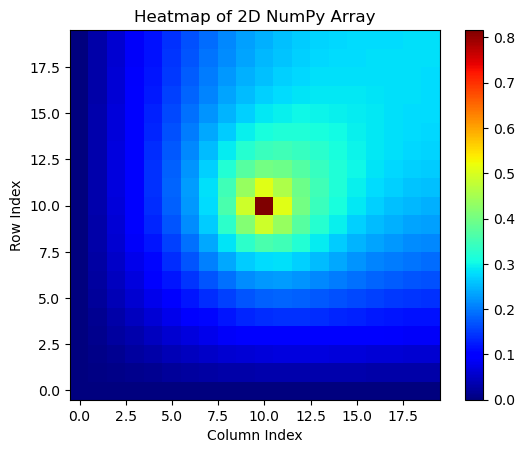

In [3]:
# test plot
Lx = Ly = 1
x_s = y_s = Lx/2
plot_GF = np.zeros((20, 20))
x = np.arange(0, Lx, 0.05)
y = np.arange(0, Ly, 0.05)
for i in range(20):
    for j in range(20):
        plot_GF[i, j] = GF_function(x[i], y[j], x_s, y_s, Lx, Ly, bc_e = "N", bc_n = "N", bc_w = "D", bc_s = "D")
        

# Plot the heatmap
plt.imshow(plot_GF, cmap='jet', interpolation='nearest', origin = 'lower')
plt.colorbar()  # Add a color bar to show the color scale
plt.title('Heatmap of 2D NumPy Array')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

### Stage 2

In [5]:
# 2
omega = 5
lambda_v = 1
Lx = Ly = 1

# boundary values (T or q)
Temp = 10
q = 3


#### 3 points in the domain

In [6]:
# SOURCE UNIFORM
# source surface area
x_s_start = 0
x_s_end = Lx
y_s_start = 0
y_s_end = Ly

# x_s and y_s array for integral calculation
n_step_s = 20
step_s_x = (x_s_end-x_s_start)/n_step_s
step_s_y = (y_s_end-y_s_start)/n_step_s
x_s = np.linspace(x_s_start, x_s_end, n_step_s)
y_s = np.linspace(y_s_start, y_s_end, n_step_s)

# Homogenoeus dirichlet everywhere
T_xy1_dirichlet_unif = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "D", "D", "D", "D", Temp, q)
T_xy2_dirichlet_unif = HeatEq_2D_point(0.5, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "D", "D", "D", "D", Temp, q)
T_xy3_dirichlet_unif = HeatEq_2D_point(0.7, 0.3, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "D", "D", "D", "D", Temp, q)

# Homogeneus Neumann + Dirichlet
T_xy1_neudir_unif = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "N", "N", "D", "D", Temp, q)
T_xy2_neudir_unif = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "N", "N", "D", "D", Temp, q)
T_xy3_neudir_unif = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "N", "N", "D", "D", Temp, q)


# SOURCE SMALL REGION
# source surface area
x_s_start = Lx/3
x_s_end = 2*x_s_start
y_s_start = Ly/3
y_s_end = 2*y_s_start

# x_s and y_s array for integral calculation
n_step_s = 20
step_s_x = (x_s_end-x_s_start)/n_step_s
step_s_y = (y_s_end-y_s_start)/n_step_s
x_s = np.linspace(x_s_start, x_s_end, n_step_s)
y_s = np.linspace(y_s_start, y_s_end, n_step_s)

# Homogenoeus dirichlet everywhere
T_xy1_dirichlet_small = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "D", "D", "D", "D", Temp, q)
T_xy2_dirichlet_small = HeatEq_2D_point(0.5, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "D", "D", "D", "D", Temp, q)
T_xy3_dirichlet_small = HeatEq_2D_point(0.7, 0.3, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "D", "D", "D", "D", Temp, q)

# Homogeneus Neumann + Dirichlet
T_xy1_neudir_small = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "N", "N", "D", "D", Temp, q)
T_xy2_neudir_small = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "N", "N", "D", "D", Temp, q)
T_xy3_neudir_small = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "N", "N", "D", "D", Temp, q)


### Whole field

In [8]:
# SOURCE UNIFORM
# source surface area
x_s_start = 0
x_s_end = Lx
y_s_start = 0
y_s_end = Ly

# x_s and y_s array for integral calculation
n_step_s = 20
step_s_x = (x_s_end-x_s_start)/n_step_s
step_s_y = (y_s_end-y_s_start)/n_step_s
x_s = np.linspace(x_s_start, x_s_end, n_step_s)
y_s = np.linspace(y_s_start, y_s_end, n_step_s)

# x y grid
x = np.linspace(0, Lx, n_step_s)
y = np.linspace(0, Ly, n_step_s)

# Homogenoeus dirichlet everywhere
T_field_dirichlet_unif = np.zeros((n_step_s, n_step_s))
for i in range(len(x)):
    for j in range(len(x)):
        T_field_dirichlet_unif[i, j] = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "D", "D", "D", "D", Temp, q)

# Homogeneus Neumann + Dirichlet
T_field_dirichlet_unif = np.zeros((n_step_s, n_step_s))
for i in range(len(x)):
    for j in range(len(x)):
        T_field_dirichlet_unif[i, j] = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "N", "N", "D", "D", Temp, q)


# SOURCE SMALL REGION
# source surface area
x_s_start = Lx/3
x_s_end = 2*x_s_start
y_s_start = Ly/3
y_s_end = 2*y_s_start

# x_s and y_s array for integral calculation
n_step_s = 20
step_s_x = (x_s_end-x_s_start)/n_step_s
step_s_y = (y_s_end-y_s_start)/n_step_s
x_s = np.linspace(x_s_start, x_s_end, n_step_s)
y_s = np.linspace(y_s_start, y_s_end, n_step_s)

# Homogenoeus dirichlet everywhere
T_field_dirichlet_small = np.zeros((n_step_s, n_step_s))
for i in range(len(x)):
    for j in range(len(x)):
        T_field_dirichlet_small[i, j] = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "D", "D", "D", "D", Temp, q)

# Homogeneus Neumann + Dirichlet
T_field_dirichlet_small = np.zeros((n_step_s, n_step_s))
for i in range(len(x)):
    for j in range(len(x)):
        T_field_dirichlet_small[i, j] = HeatEq_2D_point(0.1, 0.1, omega, lambda_v, Lx, Ly, x_s_start, x_s_end, y_s_start, y_s_end, "N", "N", "D", "D", Temp, q)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices